#**Conditional Variational AutoEncoder (C-VAE) on the MNIST handwritten digit dataset**# 

C-VAEs offer the option of imposing a condition implemented by passing a one-hot vector to the encoder layer and to the decoder layer to provide customization. In this case the one hot label denotes the digit we wish to generate. The last cell of this notebook uses the trained C-VAE to generate the number 8

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

**Hyperparameters and MNIST specific parameters**

1.   lr : Learning rate set to 0.001 for the RMSProp optimizer
2.   epochs : Number of training epochs
3.   img_dim : Dimension of flattened $28*28$ MNIST image
4.   nn_dim : Dimension of encoder/decoder Dense layer
5.   lv_dim : Dimension of latent variable representation of the VAE
6.   lab_dim : Dimension of MNIST labels


In [0]:
lr = 1e-3
epochs = 20000
img_dim = 784 #28x28 images
nn_dim = 512 #encoder/decoder dense layer
lv_dim = 2 #lower dimensional representation
lab_dim = 10 #10 labels for mnist

Xavier initialization, given by $1/{\sqrt{\frac{n}{2}}}$ where $n$ represents input dimension

In [0]:
def Xavier(in_shape):
  return tf.random_normal(shape = in_shape, stddev = 1./tf.sqrt(in_shape[0]/2.))

Initialize the weight and bias matrices using Xavier initialization

In [5]:
Weight = {'W_inp_enc' : tf.Variable(Xavier([img_dim + lab_dim, nn_dim])),
          'W_enc_mean' : tf.Variable(Xavier([nn_dim, lv_dim])),
          'W_enc_std' : tf.Variable(Xavier([nn_dim, lv_dim])),
          'W_lv_dec' : tf.Variable(Xavier([lv_dim + lab_dim, nn_dim])),
          'W_dec_out' : tf.Variable(Xavier([nn_dim, img_dim]))    
}

Bias = {'B_enc' : tf.Variable(Xavier([nn_dim])),
        'B_mean' : tf.Variable(Xavier([lv_dim])),
        'B_std' : tf.Variable(Xavier([lv_dim])),
        'B_dec' : tf.Variable(Xavier([nn_dim])),
        'B_out' : tf.Variable(Xavier([img_dim]))
}

Instructions for updating:
Colocations handled automatically by placer.


**Network definition**

1.   Input layer (shape = $[batch\_size, 794]$)
2.   Encoder layer (input shape = $[batch\_size, 784]$, output shape = $[batch\_size, 512]$, activation = $tanh()$)
3.   Mean layer (input shape = $[batch\_size, 512]$, output shape = $[batch\_size, 2]$)
4.   Standard Deviation layer (input shape = $[batch\_size, 512]$, output shape = $[batch\_size, 2]$)
5.   Latent layer (input shape = $[batch\_size, 2,2]$, output shape = $[batch\_size, 2]$)
6.   Decoder layer (input shape = $[batch\_size, 12]$, output shape = $[batch\_size, 512]$, activation = $tanh()$)
7.   Output layer (input shape = $[batch\_size, 512]$, output shape =  $[batch\_size, 784]$, activation = $sigmoid()$)



In [6]:
temp_in = tf.placeholder(tf.float32, shape = [None, img_dim])

lab = tf.placeholder(tf.float32, shape = [None, lab_dim]) #label

inp = tf.concat(axis = 1, values = [temp_in, lab])
print(inp.shape)

encoder = tf.add(tf.matmul(inp, Weight['W_inp_enc']), Bias['B_enc'])
encoder = tf.nn.tanh(encoder)

mean = tf.add(tf.matmul(encoder, Weight['W_enc_mean']), Bias['B_mean'])
stddev = tf.add(tf.matmul(encoder, Weight['W_enc_std']), Bias['B_std'])

(?, 794)


In the standard setup, derivative of the loss function with respect to the parameters of encoder network is not feasible as expectation term in the loss draws samples from the distribution defined by these parameters. Hence a reparametrization trick is used wherein a new variable $\epsilon$ drawn from $N(0,1)$ is introduced. 

The encoder function is then given by 
$g_\phi(\epsilon,X) = \mu_\phi(X) + \epsilon*\Sigma^{1/2}_\phi(X)$

In [0]:
epsilon = tf.random_normal(tf.shape(stddev), dtype = tf.float32, mean = 0.0, stddev = 1.0)
latent_layer = tf.add(mean, tf.exp(0.5*stddev)*epsilon)

In [0]:
decoder_in = tf.concat(axis = 1, values = [latent_layer, lab])
decoder = tf.add(tf.matmul(decoder_in, Weight['W_lv_dec']), Bias['B_dec'])
decoder = tf.nn.tanh(decoder)

In [9]:
out = tf.add(tf.matmul(decoder, Weight['W_dec_out']), Bias['B_out'])
out = tf.nn.sigmoid(out)
out.shape

TensorShape([Dimension(None), Dimension(784)])

The loss function includes two parts

1. Data fidelity loss
> The data fidelity or reconstruction loss is given by $L_{df}(X,\hat{X}) = X*\log(\hat{X}) + (1 - X)*\log(1 - \hat{X})$ and is used to measure the quality of reconstruction of the image by comparing the generated output $\hat{X}$ to the original image $X$
2. KL divergence 
> The KL divergence loss aims to capture $D_{KL}(q_\phi(z|x) || p_\theta(z))$ or the difference in distributions of the functions defined by the encoder and the decoder modules. Proper selection of $p_\theta$ can effectively mean that KL divergence loss acts as an inherent regularizer



The loss function is hence given as $L(\theta, \phi) = \alpha*L_{df}(X,\hat{X}) + \beta*D_{KL}(q_\phi(z|x) || p_\theta(z))$ where $\alpha$ and $\beta$ are network hyperparameters

In [0]:
def loss_fn(original, reconstructed):
  eps = 1e-10
  df_loss = original*tf.log(eps + reconstructed) + ((1 - original)*tf.log(eps + 1 - reconstructed))
  df_loss = -tf.reduce_sum(df_loss, 1)
  
  kl_div = 1 + stddev - tf.square(mean) - tf.exp(stddev)
  kl_div = -0.5*tf.reduce_sum(kl_div, 1)
  
  alpha = 1
  beta = 1
  
  return tf.reduce_mean(alpha*df_loss + beta*kl_div)

In [11]:
loss = loss_fn(temp_in, out)
optimizer = tf.train.RMSPropOptimizer(lr).minimize(loss)

Instructions for updating:
Use tf.cast instead.


Load, verify and visualize the MNIST dataset

In [0]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [34]:
y_train = y_train.reshape(-1)
y_train[:6]
y_train = np.eye(10)[y_train]
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

Train the network with the previously set hyperparameters without using mini-batches

In [35]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

x_train = np.reshape(x_train, [-1, img_dim])

losses = []

for i in range(10000):
  _, loss_val = sess.run([optimizer, loss], feed_dict = {temp_in: x_train, lab: y_train})
  losses.append(loss_val)
  if i%100 == 0:
    print("Loss after {0} epochs is {1} ".format(i, loss_val))

Loss after 0 epochs is 604.912841796875 
Loss after 100 epochs is 184.06077575683594 
Loss after 200 epochs is 166.2649688720703 
Loss after 300 epochs is 156.2147979736328 
Loss after 400 epochs is 150.01234436035156 
Loss after 500 epochs is 150.2206573486328 
Loss after 600 epochs is 144.87857055664062 
Loss after 700 epochs is 143.74839782714844 
Loss after 800 epochs is 142.73272705078125 
Loss after 900 epochs is 142.265869140625 
Loss after 1000 epochs is 141.13067626953125 
Loss after 1100 epochs is 139.7094268798828 
Loss after 1200 epochs is 139.87742614746094 
Loss after 1300 epochs is 138.4971466064453 
Loss after 1400 epochs is 139.5435791015625 
Loss after 1500 epochs is 140.86917114257812 
Loss after 1600 epochs is 137.1802978515625 
Loss after 1700 epochs is 136.58966064453125 
Loss after 1800 epochs is 135.98751831054688 
Loss after 1900 epochs is 135.53945922851562 
Loss after 2000 epochs is 135.42413330078125 
Loss after 2100 epochs is 135.45297241210938 
Loss after 

To test the network, we require only the decoder module and we feed noise in the place of the latent encodings to the decoder Dense layer

In [0]:
noise = tf.placeholder(tf.float32, shape = [None, lv_dim])
labs = tf.placeholder(tf.float32, shape = [None, lab_dim])
dec_inp = tf.concat(axis = 1, values = [noise, labs])
decoder = tf.add(tf.matmul(dec_inp, Weight['W_lv_dec']), Bias['B_dec'])
decoder = tf.nn.tanh(decoder)
out = tf.add(tf.matmul(decoder, Weight['W_dec_out']), Bias['B_out'])
out = tf.nn.sigmoid(out)

Saving the model to Drive

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
saver = tf.train.Saver()
save_path = saver.save(sess, "/content/drive/My Drive/model.ckpt")

Visualizing the decoder output by constructing a $20*20$ grid sampled for varying latent variable encodings. Unlike the standard VAE, our goal here is to generate the number 8

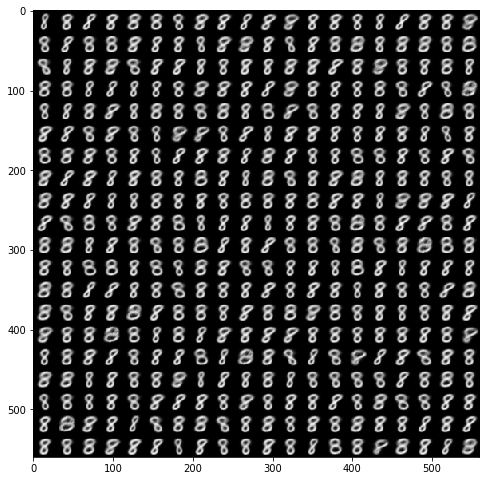

In [40]:
n = 20
x_limit = np.linspace(-2,2,n)
y_limit = np.linspace(-2,2,n)

test_img = np.empty((28*n,28*n))

digit_lab = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]*32)

for i,zi in enumerate(x_limit):
  for j,pi in enumerate(y_limit):
    #gen_layer = np.array([[zi,pi]] * 32)
    gen_layer = np.random.normal(0,1, size = [32, lv_dim])
    gen_img = sess.run(out, feed_dict = {noise : gen_layer, labs : digit_lab})
    test_img[(n-i-1)*28:(n-i)*28, j*28:(j+1)*28] = gen_img[0].reshape(28,28)
    
plt.figure(figsize = (8,10))
X,Y = np.meshgrid(x_limit, y_limit)
plt.imshow(test_img, origin = 'upper', cmap = 'gray')
plt.grid(False)
plt.show()

Plot the losses over the $10^4$ epochs

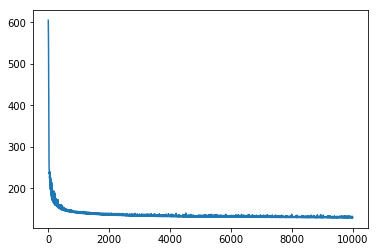

In [42]:
epochs = np.arange(len(losses))
plt.plot(epochs, losses)